In [1]:
import pandas as pd
import numpy as np 
import re 
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB

In [2]:
column_names=['Tweet_ID','Entity','Sentiment','Tweet_content']

train = pd.read_csv("datasets/twitter/twitter_training.csv",
                    sep=',',names=column_names)


validation = pd.read_csv("datasets/twitter/twitter_validation.csv",
                    sep=',',names=column_names)

In [3]:
train.head()

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
validation.head()

,Tweet_ID,Entity,Sentiment,Tweet_content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [5]:
# information of the dataset
print(f"Train dataset shape {train.shape}")
print(f"Validation dataset shape {validation.shape}")

Train dataset shape (74682, 4)
Validation dataset shape (1000, 4)


In [6]:
# checking nan values 
print("\t\t\tTrain dataset")
print(train.isna().sum())
print("*"*40)
print("\t\t\tValidation dataset")
print(validation.isna().sum())

			Train dataset
Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64
****************************************
			Validation dataset
Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64


In [7]:
# checking duplicated values
print("\t\t\tTrain dataset")
print(train.duplicated().sum())
print("*"*40)
print("\t\t\tValidation dataset")
print(validation.duplicated().sum())

			Train dataset
2700
****************************************
			Validation dataset
0


In [8]:
# remove dupicate and nan values
train.dropna(inplace=True)
train.drop_duplicates(inplace=True)

In [9]:
def remove_urls(text):
    """Berilgan matndan URL larini o'chiradi"""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


def remove_emojis(text):
    """Berilgan matndan emojilarni o'chiradi"""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emojilar
                               u"\U0001F300-\U0001F5FF"  # simvollar va diagrammalar
                               u"\U0001F680-\U0001F6FF"  # transport va turli joylar
                               u"\U0001F1E0-\U0001F1FF"  # davlat bayroqlari
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251"  # alamatchilik belgilari
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [10]:
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: remove_emojis(x))
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: remove_urls(x))

validation['Tweet_content'] = validation['Tweet_content'].apply(lambda x: remove_emojis(x))
validation['Tweet_content'] = validation['Tweet_content'].apply(lambda x: remove_urls(x))

In [11]:
train['text_lens']=train['Tweet_content'].apply(lambda x: len(x))
validation['text_lens']=validation['Tweet_content'].apply(lambda x: len(x))

## Data visualization

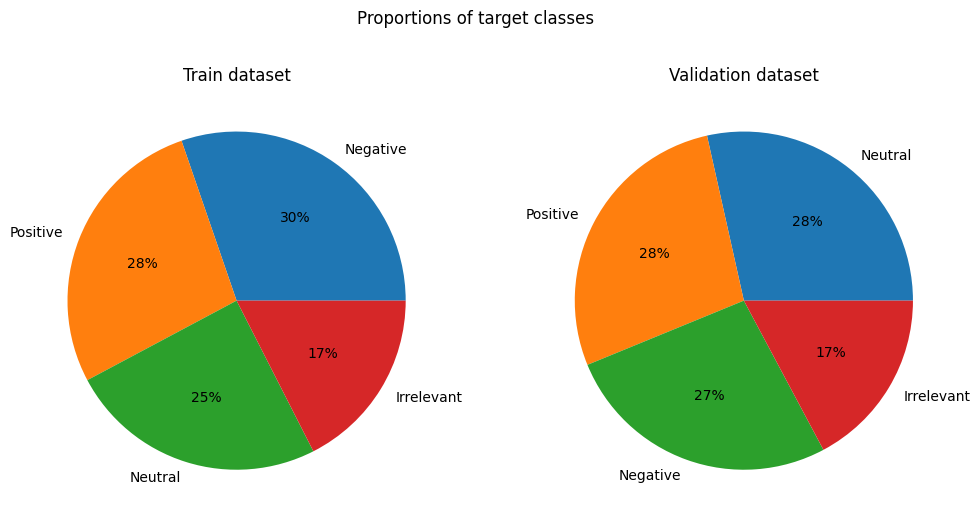

In [12]:
fig , ax = plt.subplots(1,2,figsize=(12,6))

ax[0].pie(train['Sentiment'].value_counts(),labels=train['Sentiment'].value_counts().index,autopct='%.f%%')
ax[1].pie(validation['Sentiment'].value_counts(),labels=validation['Sentiment'].value_counts().index,autopct='%.f%%')

fig.suptitle("Proportions of target classes")
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

In [14]:
#Count information per category
data1=train.groupby(by=["Entity","Sentiment"]).count().reset_index()
data1.head()

,Entity,Sentiment,Tweet_ID,Tweet_content,text_lens
0,Amazon,Irrelevant,185,185,185
1,Amazon,Negative,565,565,565
2,Amazon,Neutral,1197,1197,1197
3,Amazon,Positive,302,302,302
4,ApexLegends,Irrelevant,185,185,185


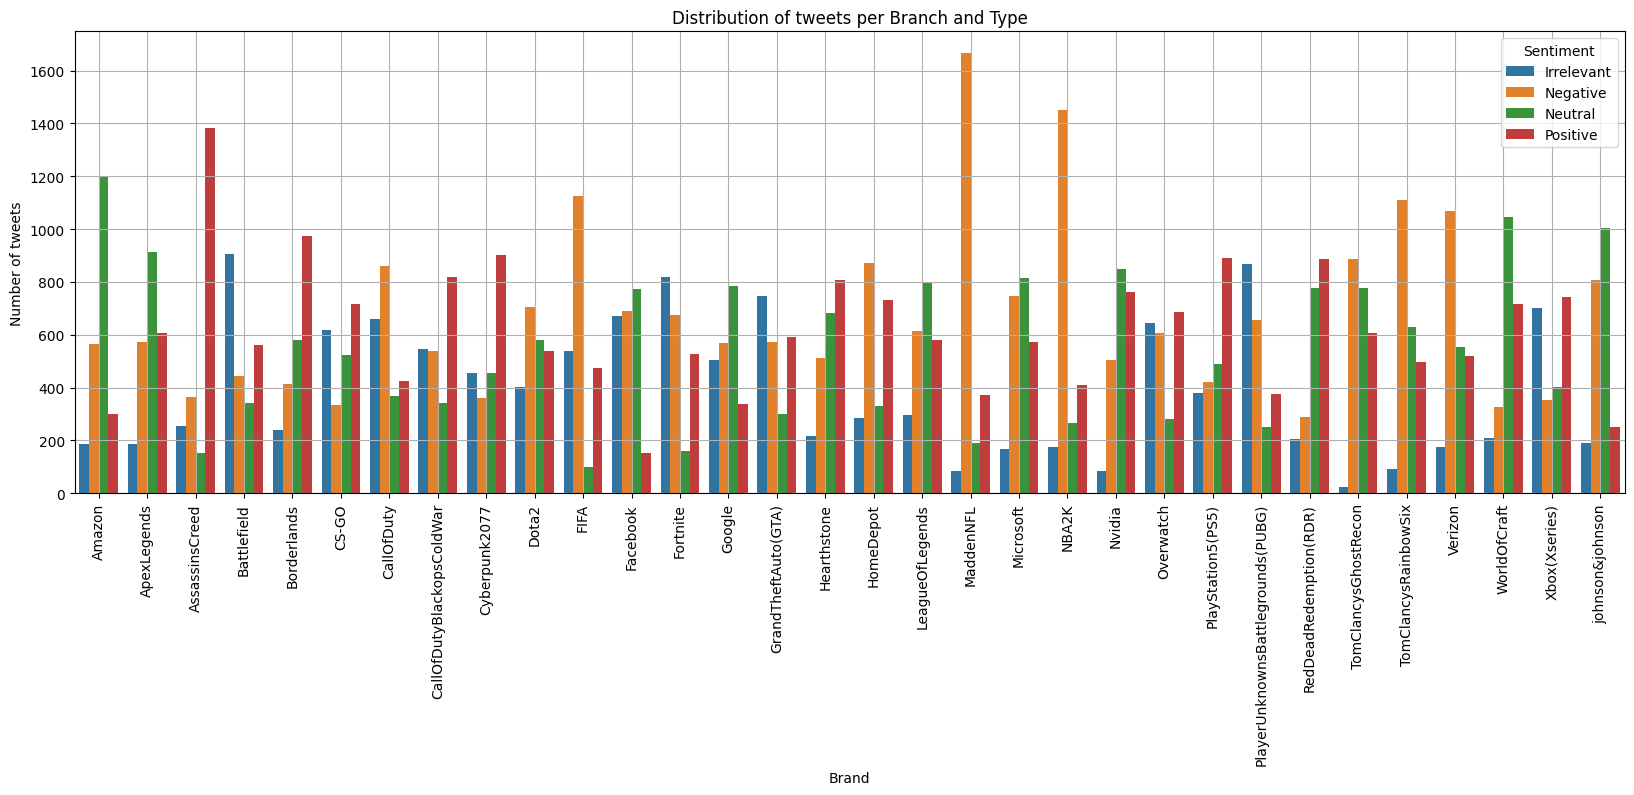

In [15]:
#Figure of comparison per branch
plt.figure(figsize=(20,6))
sns.barplot(data=data1,x="Entity",y="Tweet_ID",hue='Sentiment')
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type")
plt.show()

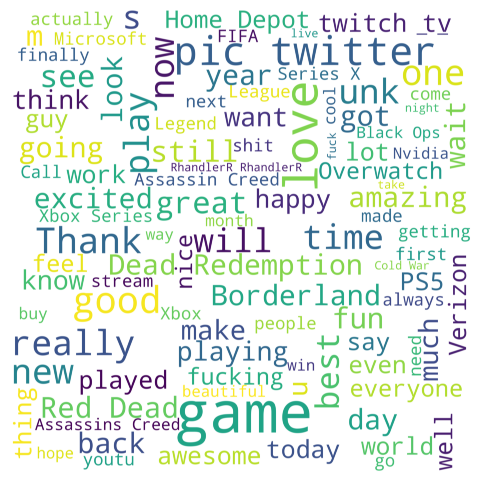

In [16]:
word_cloud_text = ''.join(train[train["Sentiment"]=="Positive"].Tweet_content)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

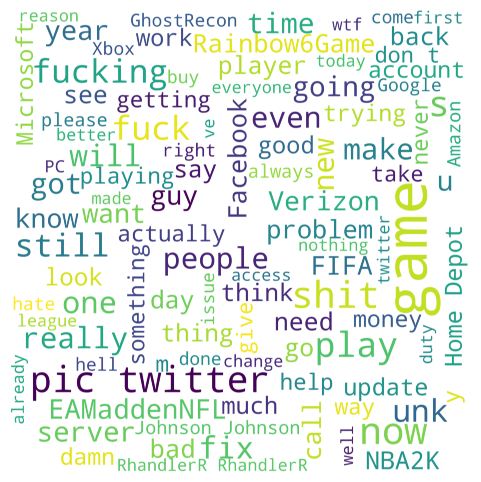

In [17]:
word_cloud_text_negative = ''.join(train[train["Sentiment"]=="Negative"].Tweet_content)
wordcloud_negative = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text_negative)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.show()

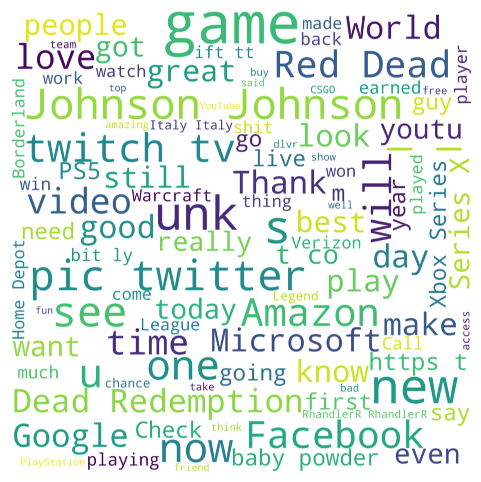

In [18]:
word_cloud_text = ''.join(train[train["Sentiment"]=="Neutral"].Tweet_content)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

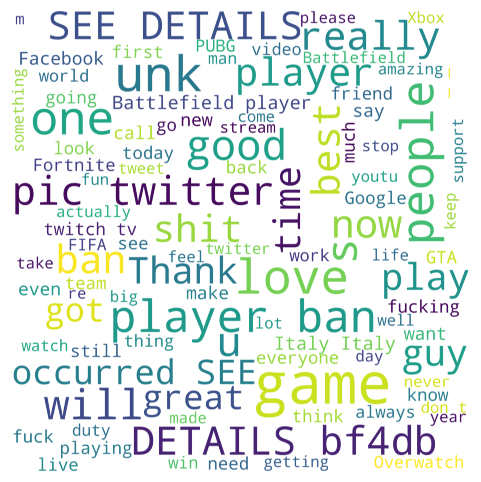

In [19]:
word_cloud_text = ''.join(train[train["Sentiment"]=="Irrelevant"].Tweet_content)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Data Preprocessing

In [20]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#remove outliers
train = remove_outlier(train,'text_lens')

In [22]:
# Tokenization and lemmatization
nlp=spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    filtered_tokens=[]
    for token in doc:
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)
    

train['preprocessed_text']=train['Tweet_content'].apply(lambda x: preprocess(x))
validation['preprocessed_text']=validation['Tweet_content'].apply(lambda x: preprocess(x))

In [23]:
# train test split
from sklearn.model_selection import train_test_split

X_train ,X_test , y_train, y_test = train_test_split(
    train[['preprocessed_text']],
    train[['Sentiment']],
    test_size=0.2,
    random_state=42
)

In [24]:
# Data representation
# Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer()

X_train_vect= vectorizer.fit_transform(X_train['preprocessed_text'])
X_test_vect= vectorizer.transform(X_test['preprocessed_text'])

y_train=y_train['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})
y_test=y_test['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})

In [25]:
validation_X = vectorizer.transform(validation['preprocessed_text'])
validation_y = validation['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})

In [26]:
# Multinomial Naive Bayes Method
model = MultinomialNB()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.70      0.80      0.74      3900
           1       0.65      0.89      0.75      4238
           2       0.84      0.64      0.73      3518
           3       0.94      0.44      0.60      2516

    accuracy                           0.72     14172
   macro avg       0.78      0.69      0.70     14172
weighted avg       0.76      0.72      0.72     14172



In [27]:
# Random Forest Method
model = RandomForestClassifier()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3900
           1       0.92      0.92      0.92      4238
           2       0.93      0.90      0.91      3518
           3       0.97      0.85      0.91      2516

    accuracy                           0.91     14172
   macro avg       0.92      0.90      0.91     14172
weighted avg       0.91      0.91      0.91     14172



In [28]:
# Extra Trees Method
model_extra = ExtraTreesClassifier()
model_extra.fit(X_train_vect,y_train)
y_predict= model_extra.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      3900
           1       0.94      0.94      0.94      4238
           2       0.95      0.91      0.93      3518
           3       0.98      0.88      0.93      2516

    accuracy                           0.92     14172
   macro avg       0.93      0.92      0.93     14172
weighted avg       0.93      0.92      0.93     14172



In [29]:
import pickle
with open('model_extra.pkl', 'wb') as file:
    pickle.dump(model_extra, file)
    
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

In [30]:
train.to_csv("train_data.csv")
validation.to_csv('validation_data.csv')

In [42]:
text = 'Your support team is cool, but your customer service is terrible. I have been waiting for a response for 2 days.'
text1='Rock-Hard La Varlope, RARE & POWERFUL, HANDSOME JACKPOT, Borderlands 3 (Xbox) dlvr.it/RMTrgF '
text_final = vectorizer.transform([text])

predict = model_extra.predict(text_final)

In [43]:
kayfiyatlar={0:"Positive",1:"Negative",2:"Neutral",3:"Irrelevant"}
kayfiyatlar[list(predict)[0]]

'Negative'